Welcome

In [1]:
DEBUG = False
MODE = 'TRAIN'
# MODE = 'INFERENCE'
MODEL_DIR = '../input/optiver-lgb-and-te-baseline'

# Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import pathlib
from tqdm.auto import tqdm
import json
from multiprocessing import Pool, cpu_count
import time
import requests as re
from datetime import datetime
from dateutil.relativedelta import relativedelta, FR

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import glob
import os
from sklearn import model_selection
import joblib
import lightgbm as lgb

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2, venn3
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')

import warnings
warnings.simplefilter('ignore')

pd.get_option("display.max_columns")

20

# Config

In [3]:
class CFG:
    INPUT_DIR = '../input/optiver-realized-volatility-prediction'
    OUTPUT_DIR = './'
    N_SPLITS = 10
    SEED = 46

In [4]:
# Logging is always nice for your experiment:)
def init_logger(log_file='train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = init_logger(log_file=f'{CFG.OUTPUT_DIR}/baseline.log')
logger.info(f'Start Logging...')

Start Logging...


# Load data

Data description found in :

https://www.kaggle.com/c/optiver-realized-volatility-prediction/data

## Train, test, and sample submission
train.csv The ground truth values for the training set.

stock_id - Same as above, but since this is a csv the column will load as an integer instead of categorical.
time_id - Same as above.
target - The realized volatility computed over the 10 minute window following the feature data under the same stock/time_id. There is no overlap between feature and target data. You can find more info in our tutorial notebook.
test.csv Provides the mapping between the other data files and the submission file. As with other test files, most of the data is only available to your notebook upon submission with just the first few rows available for download.

stock_id - Same as above.
time_id - Same as above.
row_id - Unique identifier for the submission row. There is one row for each existing time ID/stock ID pair. Each time window is not necessarily containing every individual stock.
sample_submission.csv - A sample submission file in the correct format.

row_id - Same as in test.csv.
target - Same definition as in train.csv. The benchmark is using the median target value from train.csv.

In [5]:
train = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'train.csv'))

logger.info('Train data: {}'.format(train.shape))
train.head()

Train data: (428932, 3)


,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [6]:
train['stock_id'].value_counts()

0      3830
81     3830
94     3830
93     3830
90     3830
       ... 
13     3829
75     3829
100    3829
80     3820
38     3815
Name: stock_id, Length: 112, dtype: int64

In [7]:
train['time_id'].value_counts()

8196     112
25504    112
8623     112
17315    112
15276    112
        ... 
6172     111
32186    111
10765    111
27795    111
29802    111
Name: time_id, Length: 3830, dtype: int64

<AxesSubplot:>

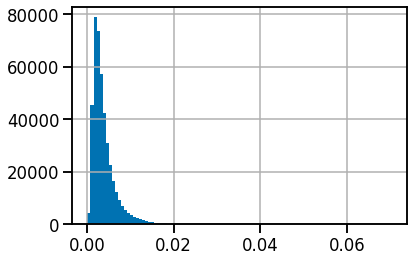

In [8]:
train['target'].hist(bins=100)

0it [00:00, ?it/s]

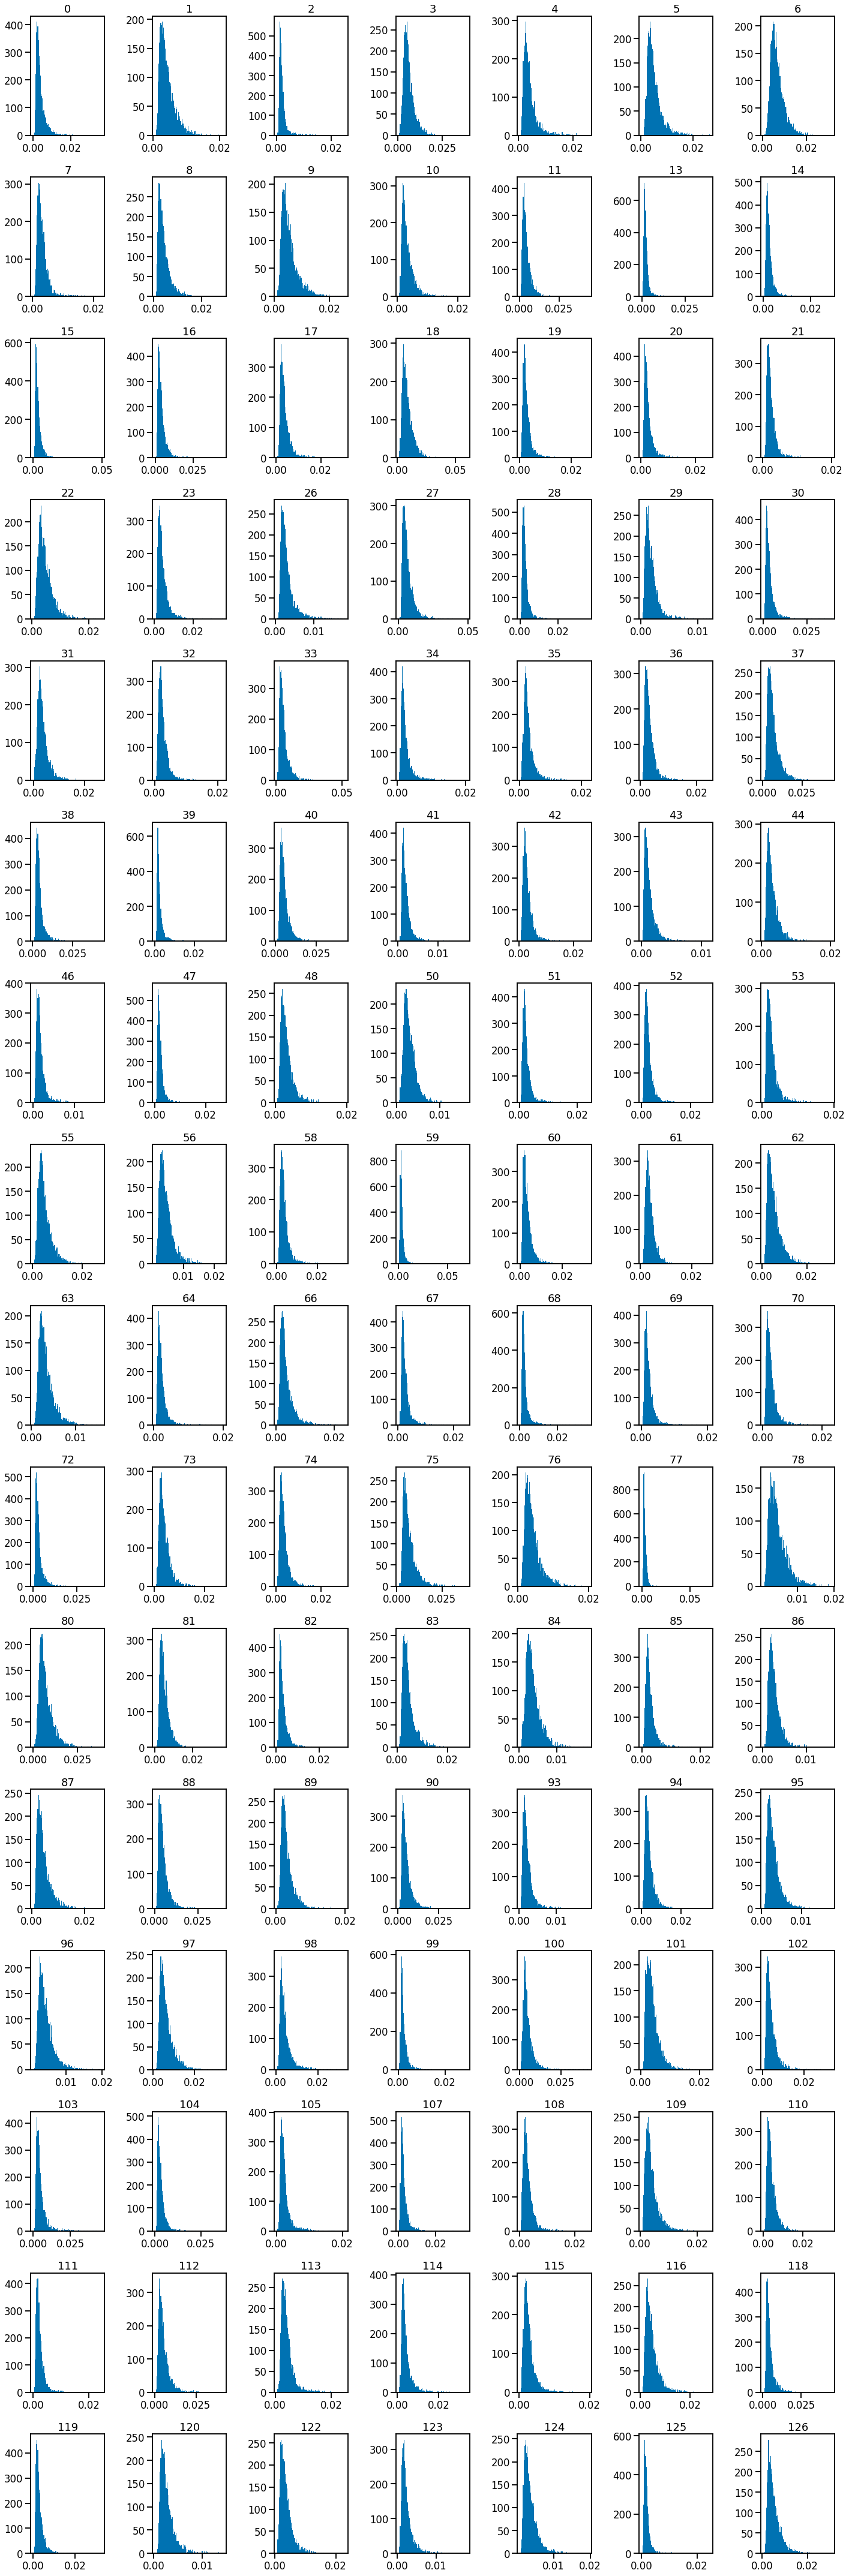

In [9]:
fig, ax = plt.subplots(16, 7, figsize=(20, 60))
ax = ax.flatten()

for i, stock_id in tqdm(enumerate(train['stock_id'].unique())):
    ax[i].hist(train.query('stock_id == @stock_id')['target'], bins=100)
    ax[i].set_title(stock_id)
plt.tight_layout()

In [10]:
test = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'test.csv'))

logger.info('Test data: {}'.format(test.shape))
test.head()

Test data: (3, 3)


,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


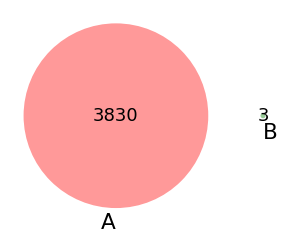

In [11]:
venn2([
    set(train['time_id'])
    , set(test['time_id'])
])

In [12]:
ss = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'sample_submission.csv'))

logger.info('Sample submission: {}'.format(ss.shape))
ss.head()

Sample submission: (3, 2)


,row_id,target
0,0-4,0.003048
1,0-32,0.003048
2,0-34,0.003048


## Book

book_[train/test].parquet A parquet file partitioned by stock_id. Provides order book data on the most competitive buy and sell orders entered into the market. The top two levels of the book are shared. The first level of the book will be more competitive in price terms, it will then receive execution priority over the second level.

stock_id - ID code for the stock. Not all stock IDs exist in every time bucket. Parquet coerces this column to the categorical data type when loaded; you may wish to convert it to int8.
time_id - ID code for the time bucket. Time IDs are not necessarily sequential but are consistent across all stocks.
seconds_in_bucket - Number of seconds from the start of the bucket, always starting from 0.
bid_price[1/2] - Normalized prices of the most/second most competitive buy level.
ask_price[1/2] - Normalized prices of the most/second most competitive sell level.
bid_size[1/2] - The number of shares on the most/second most competitive buy level.
ask_size[1/2] - The number of shares on the most/second most competitive sell level.

## Trade

trade_[train/test].parquet A parquet file partitioned by stock_id. Contains data on trades that actually executed. Usually, in the market, there are more passive buy/sell intention updates (book updates) than actual trades, therefore one may expect this file to be more sparse than the order book.

stock_id - Same as above.
time_id - Same as above.
seconds_in_bucket - Same as above. Note that since trade and book data are taken from the same time window and trade data is more sparse in general, this field is not necessarily starting from 0.
price - The average price of executed transactions happening in one second. Prices have been normalized and the average has been weighted by the number of shares traded in each transaction.
size - The sum number of shares traded.
order_count - The number of unique trade orders taking place.

In [13]:
train_book_stocks = os.listdir(os.path.join(CFG.INPUT_DIR, 'book_train.parquet'))

if DEBUG:
    logger.info('Debug mode: using 3 stocks only')
    train_book_stocks = train_book_stocks[:3]

logger.info('{:,} train book stocks: {}'.format(len(train_book_stocks), train_book_stocks))

112 train book stocks: ['stock_id=97', 'stock_id=43', 'stock_id=21', 'stock_id=72', 'stock_id=4', 'stock_id=112', 'stock_id=22', 'stock_id=105', 'stock_id=116', 'stock_id=63', 'stock_id=14', 'stock_id=87', 'stock_id=122', 'stock_id=59', 'stock_id=113', 'stock_id=23', 'stock_id=38', 'stock_id=76', 'stock_id=125', 'stock_id=15', 'stock_id=67', 'stock_id=27', 'stock_id=30', 'stock_id=1', 'stock_id=66', 'stock_id=96', 'stock_id=9', 'stock_id=13', 'stock_id=18', 'stock_id=50', 'stock_id=32', 'stock_id=95', 'stock_id=110', 'stock_id=101', 'stock_id=114', 'stock_id=98', 'stock_id=118', 'stock_id=82', 'stock_id=19', 'stock_id=5', 'stock_id=70', 'stock_id=58', 'stock_id=108', 'stock_id=75', 'stock_id=2', 'stock_id=62', 'stock_id=0', 'stock_id=42', 'stock_id=83', 'stock_id=40', 'stock_id=81', 'stock_id=26', 'stock_id=61', 'stock_id=78', 'stock_id=8', 'stock_id=104', 'stock_id=34', 'stock_id=80', 'stock_id=124', 'stock_id=35', 'stock_id=111', 'stock_id=77', 'stock_id=44', 'stock_id=16', 'stock_id

In [14]:
# load stock_id=0
def load_book(stock_id=0, data_type='train'):
    """
    load parquest book data for given stock_id
    """
    book_df = pd.read_parquet(os.path.join(CFG.INPUT_DIR, f'book_{data_type}.parquet/stock_id={stock_id}'))
    book_df['stock_id'] = stock_id
    book_df['stock_id'] = book_df['stock_id'].astype(np.int8)
    
    return book_df

def load_trade(stock_id=0, data_type='train'):
    """
    load parquest trade data for given stock_id
    """
    trade_df = pd.read_parquet(os.path.join(CFG.INPUT_DIR, f'trade_{data_type}.parquet/stock_id={stock_id}'))
    trade_df['stock_id'] = stock_id
    trade_df['stock_id'] = trade_df['stock_id'].astype(np.int8)
    
    return trade_df

book0 = load_book(0)
logger.info('Book data of stock id = 1: {}'.format(book0.shape))
book0.head()

Book data of stock id = 1: (917553, 11)


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [15]:
book0.tail()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28,0
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28,0
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28,0
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28,0
917552,32767,582,0.998275,0.998754,0.998179,0.998946,92,90,26,28,0


In [16]:
trade0 = load_trade(0)
logger.info('Book data of stock id = 1: {}'.format(trade0.shape))
trade0.head()

Book data of stock id = 1: (123443, 6)


,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [17]:
trade0.tail()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
123438,32767,471,0.998659,200,3,0
123439,32767,517,0.998515,90,1,0
123440,32767,523,0.998563,1,1,0
123441,32767,542,0.998803,90,4,0
123442,32767,567,0.998547,300,3,0


In [18]:
book_df = book0.merge(
    trade0
    , how='outer'
    , on=['time_id', 'stock_id', 'seconds_in_bucket']
)

print(book_df.shape)
book_df.head()

(917553, 14)


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,price,size,order_count
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0,NaN,NaN,NaN
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,NaN,NaN,NaN
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,NaN,NaN,NaN
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,NaN,NaN,NaN
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,NaN,NaN,NaN


In [19]:
book_df.tail()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,price,size,order_count
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28,0,NaN,NaN,NaN
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28,0,NaN,NaN,NaN
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28,0,NaN,NaN,NaN
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28,0,NaN,NaN,NaN
917552,32767,582,0.998275,0.998754,0.998179,0.998946,92,90,26,28,0,NaN,NaN,NaN


In [20]:
def fix_jsonerr(df):
    """
    fix json column error for lightgbm
    """
    df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]
    return df

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series_log_return):
    series_log_return = log_return(series_log_return)
    return np.sqrt(np.sum(series_log_return ** 2))

def fe_row(book):
    """
    Feature engineering (just volatility for now) for each row
    """
    
    # volatility
    for i in [1, 2, ]:  
        # wap
        book[f'book_wap{i}'] = (book[f'bid_price{i}'] * book[f'ask_size{i}'] +
                        book[f'ask_price{i}'] * book[f'bid_size{i}']) / (
                               book[f'bid_size{i}']+ book[f'ask_size{i}'])
        
    # mean wap
    book['book_wap_mean'] = (book['book_wap1'] + book['book_wap2']) / 2
    
    # wap diff
    book['book_wap_diff'] = book['book_wap1'] - book['book_wap2']
    
    # other orderbook features
    book['book_price_spread'] = (book['ask_price1'] - book['bid_price1']) / (book['ask_price1'] + book['bid_price1'])
    book['book_bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['book_ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['book_total_volume'] = book['ask_size1'] + book['ask_size2'] + book['bid_size1'] + book['bid_size2']
    book['book_volume_imbalance'] = (book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2'])
    
    return book    

def fe_agg(book_df):
    """
    feature engineering (aggregation by stock_id x time_id)   
    """ 
            
    # features
    book_feats = book_df.columns[book_df.columns.str.startswith('book_')].values.tolist()
    trade_feats = ['price', 'size', 'order_count', 'seconds_in_bucket']
        
    # agg trade features
    trade_df = book_df.groupby(['time_id', 'stock_id'])[trade_feats].agg([
        'sum', 'mean', 'std', 'max', 'min'
    ]).reset_index()
    
    # agg volatility features
    fe_df = book_df.groupby(['time_id', 'stock_id'])[book_feats].agg([
        realized_volatility
    ]).reset_index()
    fe_df.columns = [" ".join(col).strip() for col in fe_df.columns.values]
    
    # merge
    fe_df = fe_df.merge(
        trade_df
        , how='left'
        , on=['time_id', 'stock_id']
    )
    
    return fe_df
    
def fe_all(book_df):
    """
    perform feature engineerings
    """
      
    # row-wise feature engineering
    book_df = fe_row(book_df)
    
    # feature engineering agg by stock_id x time_id 
    fe_df = fe_agg(book_df)
    
    return fe_df
    
def book_fe_by_stock(stock_id=0):
    """
    load orderbook and trade data for the given stock_id and merge
    
    """
    # load data
    book_df = load_book(stock_id, 'train')
    trade_df = load_trade(stock_id, 'train')
    book_feats = book_df.columns.values.tolist()
    
    # merge
    book_df = book_df.merge(
        trade_df
        , how='outer'
        , on=['time_id', 'seconds_in_bucket', 'stock_id']
    )
    
    # sort by time
    book_df = book_df.sort_values(by=['time_id', 'seconds_in_bucket'])
    
    # fillna for book_df
    book_df[book_feats] = book_df[book_feats].fillna(method='ffill')
    
    # feature engineering
    fe_df = fe_all(book_df)
    return fe_df

def book_fe_by_stock_test(stock_id=0):
    """
    same function but for the test
    
    """
    # load data
    book_df = load_book(stock_id, 'test')
    trade_df = load_trade(stock_id, 'test')
    book_feats = book_df.columns.values.tolist()
    
    # merge
    book_df = book_df.merge(
        trade_df
        , how='outer'
        , on=['time_id', 'seconds_in_bucket', 'stock_id']
    )
    
    # sort by time
    book_df = book_df.sort_values(by=['time_id', 'seconds_in_bucket'])
    
    # fillna for book_df
    book_df[book_feats] = book_df[book_feats].fillna(method='ffill')
    
    # feature engineering
    fe_df = fe_all(book_df)
    return fe_df
    
def book_fe_all(stock_ids, data_type='train'): 
    """
    Feature engineering with multithread processing
    """
    # feature engineering agg by stock_id x time_id
    with Pool(cpu_count()) as p:
        if data_type == 'train':
            feature_dfs = list(tqdm(p.imap(book_fe_by_stock, stock_ids), total=len(stock_ids)))
        elif data_type == 'test':
            feature_dfs = list(tqdm(p.imap(book_fe_by_stock_test, stock_ids), total=len(stock_ids)))      
        
    fe_df = pd.concat(feature_dfs)
    
    # feature engineering agg by stock_id
    vol_feats = [f for f in fe_df.columns if ('realized' in f) & ('wap' in f)]
    if data_type == 'train':
        # agg
        stock_df = fe_df.groupby('stock_id')[vol_feats].agg(['mean', 'std', 'max', 'min', ]).reset_index()
        
        # fix column names
        stock_df.columns = ['stock_id'] + [f'{f}_stock' for f in stock_df.columns.values.tolist()[1:]]        
        stock_df = fix_jsonerr(stock_df)
    
    # feature engineering agg by time_id
    time_df = fe_df.groupby('time_id')[vol_feats].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    time_df.columns = ['time_id'] + [f'{f}_time' for f in time_df.columns.values.tolist()[1:]]
    
    # merge
    fe_df = fe_df.merge(
        time_df
        , how='left'
        , on='time_id'
    )
    
    # make sure to fix json error for lighgbm
    fe_df = fix_jsonerr(fe_df)
    
    # out
    if data_type == 'train':
        return fe_df, stock_df
    elif data_type == 'test':
        return fe_df

In [21]:
%%time

if MODE == 'TRAIN':
    # all book data feature engineering
    stock_ids = [int(i.split('=')[-1]) for i in train_book_stocks]
    book_df, stock_df = book_fe_all(stock_ids, data_type='train')

    assert book_df['stock_id'].nunique() > 2
    assert book_df['time_id'].nunique() > 2
    
    # save stock_df for the test
    stock_df.to_pickle('train_stock_df.pkl')
    logger.info('train stock df saved!')
    
    # merge
    book_df = book_df.merge(
        stock_df
        , how='left'
        , on='stock_id'
    ).merge(
        train
        , how='left'
        , on=['stock_id', 'time_id']
    ).replace([np.inf, -np.inf], np.nan).fillna(method='ffill')

    # make row_id
    book_df['row_id'] = book_df['stock_id'].astype(str) + '-' + book_df['time_id'].astype(str)
    book_df.to_pickle('book_df.pkl')

    print(book_df.shape)
    book_df.head()

  0%|          | 0/112 [00:00<?, ?it/s]

train stock df saved!


(428932, 65)
CPU times: user 4.66 s, sys: 1.64 s, total: 6.3 s
Wall time: 19min 21s


In [22]:
# test
test_book_stocks = os.listdir(os.path.join(CFG.INPUT_DIR, 'book_test.parquet'))

logger.info('{:,} test book stocks: {}'.format(len(test_book_stocks), test_book_stocks))

# all book data feature engineering
test_stock_ids = [int(i.split('=')[-1]) for i in test_book_stocks]
test_book_df = book_fe_all(test_stock_ids, data_type='test')

# load stock_df, if inference
if MODE == 'INFERENCE':
    book_df = pd.read_pickle(f'{MODEL_DIR}/book_df.pkl')
    stock_df = pd.read_pickle(f'{MODEL_DIR}/train_stock_df.pkl')
    
# merge
test_book_df = test.merge(
    stock_df
    , how='left'
    , on='stock_id'
).merge(
    test_book_df
    , how='left'
    , on=['stock_id', 'time_id']
).replace([np.inf, -np.inf], np.nan).fillna(method='ffill')

# make row_id
test_book_df['row_id'] = test_book_df['stock_id'].astype(str) + '-' + test_book_df['time_id'].astype(str)

print(test_book_df.shape)
test_book_df.head()

1 test book stocks: ['stock_id=0']


  0%|          | 0/1 [00:00<?, ?it/s]

(3, 64)


,stock_id,time_id,row_id,__book_wap1_realized_volatility____mean___stock,__book_wap1_realized_volatility____std___stock,__book_wap1_realized_volatility____max___stock,__book_wap1_realized_volatility____min___stock,__book_wap2_realized_volatility____mean___stock,__book_wap2_realized_volatility____std___stock,__book_wap2_realized_volatility____max___stock,...,__book_wap2_realized_volatility____max___time,__book_wap2_realized_volatility____min___time,__book_wap_mean_realized_volatility____mean___time,__book_wap_mean_realized_volatility____std___time,__book_wap_mean_realized_volatility____max___time,__book_wap_mean_realized_volatility____min___time,__book_wap_diff_realized_volatility____mean___time,__book_wap_diff_realized_volatility____std___time,__book_wap_diff_realized_volatility____max___time,__book_wap_diff_realized_volatility____min___time
0,0,4,0-4,0.004459,0.003698,0.052704,0.000747,0.006856,0.005494,0.086671,...,0.000252,0.000252,0.000273,NaN,0.000273,0.000273,0.0,NaN,0.0,0.0
1,0,32,0-32,0.004459,0.003698,0.052704,0.000747,0.006856,0.005494,0.086671,...,0.000252,0.000252,0.000273,NaN,0.000273,0.000273,0.0,NaN,0.0,0.0
2,0,34,0-34,0.004459,0.003698,0.052704,0.000747,0.006856,0.005494,0.086671,...,0.000252,0.000252,0.000273,NaN,0.000273,0.000273,0.0,NaN,0.0,0.0


# Modeling

Currently,

- MODEL: LightGBM (with inverse weighting of the square of the target)
- OBJECTIVE FUNCTION: RMSE
- METRIC: RMSPE (used for early stopping)
- Validation Strategy: GroupKFold using time_id

In [23]:
target = 'target'
drops = [target, 'row_id', 'time_id']
features = [f for f in test_book_df.columns.values.tolist() if (f not in drops) & (test_book_df[f].isna().sum() == 0) & (book_df[f].isna().sum() == 0)]
cats = ['stock_id', ]

logger.info('{:,} features ({:,} categorical): {}'.format(len(features), len(cats), features))

52 features (1 categorical): ['stock_id', '__book_wap1_realized_volatility____mean___stock', '__book_wap1_realized_volatility____std___stock', '__book_wap1_realized_volatility____max___stock', '__book_wap1_realized_volatility____min___stock', '__book_wap2_realized_volatility____mean___stock', '__book_wap2_realized_volatility____std___stock', '__book_wap2_realized_volatility____max___stock', '__book_wap2_realized_volatility____min___stock', '__book_wap_mean_realized_volatility____mean___stock', '__book_wap_mean_realized_volatility____std___stock', '__book_wap_mean_realized_volatility____max___stock', '__book_wap_mean_realized_volatility____min___stock', '__book_wap_diff_realized_volatility____min___stock', 'book_wap1_realized_volatility', 'book_wap2_realized_volatility', 'book_wap_mean_realized_volatility', 'book_wap_diff_realized_volatility', 'book_price_spread_realized_volatility', 'book_bid_spread_realized_volatility', 'book_ask_spread_realized_volatility', 'book_total_volume_realize

In [24]:
# evaluation metric
def RMSPEMetric(XGBoost=False):

    def RMSPE(yhat, dtrain, XGBoost=XGBoost):

        y = dtrain.get_label()
        elements = ((y - yhat) / y) ** 2
        if XGBoost:
            return 'RMSPE', float(np.sqrt(np.sum(elements) / len(y)))
        else:
            return 'RMSPE', float(np.sqrt(np.sum(elements) / len(y))), False

    return RMSPE

In [25]:
# LightGBM parameters
params = {
    'n_estimators': 10000,
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'learning_rate': 0.01,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.9,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'seed': 46,
    'early_stopping_rounds': 100,
    'verbose': -1
} 

In [26]:
def fit_model(params, X_train, y_train, X_test, features=features, cats=[], era='stock_id', fold_type='kfold', n_fold=5, seed=42):
    """
    fit model with cross validation
    """
    
    models = []
    oof_df = X_train[['time_id', 'stock_id', target]].copy()
    oof_df['pred'] = np.nan
    y_preds = np.zeros((len(X_test),))
    
    if fold_type == 'stratifiedshuffle':
        cv = model_selection.StratifiedShuffleSplit(n_splits=n_fold, random_state=seed)
        kf = cv.split(X_train, X_train[era])
    elif fold_type == 'kfold':
        cv = model_selection.KFold(n_splits=n_fold, shuffle=True, random_state=seed)
        kf = cv.split(X_train, y_train)      
    elif fold_type == 'gkf':
        cv = model_selection.GroupKFold(n_splits=n_fold)
        kf = cv.split(X_train, y_train, X_train[era])      
    
    fi_df = pd.DataFrame()
    fi_df['features'] = features
    fi_df['importance'] = 0
        
    for fold_id, (train_index, valid_index) in tqdm(enumerate(kf)):
        # split
        X_tr = X_train.loc[train_index, features]
        X_val = X_train.loc[valid_index, features]
        y_tr = y_train.loc[train_index]
        y_val = y_train.loc[valid_index]
        
        # model (note inverse weighting)
        train_set = lgb.Dataset(X_tr, y_tr, categorical_feature=cats, weight=1/np.power(y_tr, 2))
        val_set = lgb.Dataset(X_val, y_val, categorical_feature=cats, weight=1/np.power(y_val, 2))
        model = lgb.train(
            params
            , train_set
            , valid_sets=[train_set, val_set]
            , feval=RMSPEMetric()
            , verbose_eval=250
        )
        
        # feature importance
        fi_df[f'importance_fold{fold_id}'] = model.feature_importance(importance_type="gain")
        fi_df['importance'] += fi_df[f'importance_fold{fold_id}'].values
        
        # save model
        joblib.dump(model, f'model_fold{fold_id}.pkl')
        logger.debug('model saved!')

        # predict
        oof_df['pred'].iloc[valid_index] = model.predict(X_val)
        y_pred = model.predict(X_test[features])
        y_preds += y_pred / n_fold
        models.append(model)
        
    return oof_df, y_preds, models, fi_df

if MODE == 'TRAIN':
    oof_df, y_preds, models, fi_df = fit_model(params, 
                                          book_df, 
                                          book_df[target], 
                                          test_book_df, 
                                          features=features, 
                                          cats=cats,
                                          era='time_id',
                                          fold_type='gkf', 
                                          n_fold=CFG.N_SPLITS, 
                                          seed=CFG.SEED
                                              )

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[250]	training's rmse: 0.00050702	training's RMSPE: 0.234328	valid_1's rmse: 0.000529223	valid_1's RMSPE: 0.247984
[500]	training's rmse: 0.000478436	training's RMSPE: 0.221118	valid_1's rmse: 0.000507877	valid_1's RMSPE: 0.237982
[750]	training's rmse: 0.000468381	training's RMSPE: 0.21647	valid_1's rmse: 0.000502841	valid_1's RMSPE: 0.235622
[1000]	training's rmse: 0.000460426	training's RMSPE: 0.212794	valid_1's rmse: 0.000500321	valid_1's RMSPE: 0.234441
[1250]	training's rmse: 0.00045413	training's RMSPE: 0.209884	valid_1's rmse: 0.000498833	valid_1's RMSPE: 0.233744
[1500]	training's rmse: 0.000449042	training's RMSPE: 0.207532	valid_1's rmse: 0.000497922	valid_1's RMSPE: 0.233317
[1750]	training's rmse: 0.000444845	training's RMSPE: 0.205593	valid_1's rmse: 0.000497242	valid_1's RMSPE: 0.232999
[2000]	training's rmse: 0.000440926	training's RMSPE: 0.203781	valid_1's rmse: 0.000496701	valid_1's RMSPE: 0.232745
[2250]	t

# CV (Cross-Validation) Score
How good is my model?

Performance of the naive prediction: R2 score: 0.8, RMSPE: 0.229


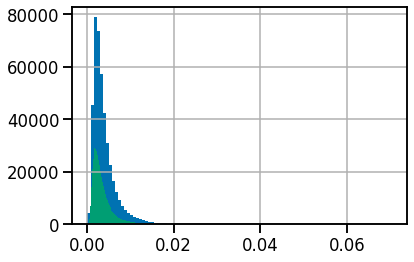

In [27]:
from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

if MODE == 'TRAIN':
    oof_df.dropna(inplace=True)
    y_true = oof_df[target].values
    y_pred = oof_df['pred'].values
    
    oof_df[target].hist(bins=100)
    oof_df['pred'].hist(bins=100)
    
    R2 = round(r2_score(y_true, y_pred), 3)
    RMSPE = round(rmspe(y_true, y_pred), 3)
    logger.info(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

We might want to take a look at by-stock performance: there may be some stocks whose volatility are difficult to predict.

In [28]:
# performance by stock_id
if MODE == 'TRAIN':
    score_df = pd.DataFrame()
    score_df['stock_id'] = oof_df['stock_id'].unique()
    score_df['R2'] = np.nan
    score_df['RMSPE'] = np.nan
    for stock_id in oof_df['stock_id'].unique():
        y_true = oof_df.query('stock_id == @stock_id')[target].values
        y_pred = oof_df.query('stock_id == @stock_id')['pred'].values
        
        R2 = round(r2_score(y_true, y_pred), 3)
        RMSPE = round(rmspe(y_true, y_pred), 3)
        logger.info(f'Performance by stock_id={stock_id}: R2 score: {R2}, RMSPE: {RMSPE}')
        
        score_df.loc[score_df['stock_id'] == stock_id, 'R2'] = R2
        score_df.loc[score_df['stock_id'] == stock_id, 'RMSPE'] = RMSPE
    
    # save score dataframe for further analysis
    score_df.to_csv('score_df.csv', index=False)
    logger.info('Scores saved!')

Performance by stock_id=97: R2 score: 0.74, RMSPE: 0.229
Performance by stock_id=43: R2 score: 0.869, RMSPE: 0.217
Performance by stock_id=21: R2 score: 0.769, RMSPE: 0.24
Performance by stock_id=72: R2 score: 0.771, RMSPE: 0.233
Performance by stock_id=4: R2 score: 0.769, RMSPE: 0.25
Performance by stock_id=112: R2 score: 0.719, RMSPE: 0.265
Performance by stock_id=22: R2 score: 0.804, RMSPE: 0.213
Performance by stock_id=105: R2 score: 0.822, RMSPE: 0.224
Performance by stock_id=116: R2 score: 0.769, RMSPE: 0.239
Performance by stock_id=63: R2 score: 0.761, RMSPE: 0.199
Performance by stock_id=14: R2 score: 0.824, RMSPE: 0.18
Performance by stock_id=87: R2 score: 0.807, RMSPE: 0.206
Performance by stock_id=122: R2 score: 0.792, RMSPE: 0.206
Performance by stock_id=59: R2 score: 0.674, RMSPE: 0.213
Performance by stock_id=113: R2 score: 0.799, RMSPE: 0.197
Performance by stock_id=23: R2 score: 0.808, RMSPE: 0.211
Performance by stock_id=38: R2 score: 0.721, RMSPE: 0.24
Performance by 

# Feature Importance
Let's see top features for the prediction.

|    | features                                            |       importance |
|---:|:----------------------------------------------------|-----------------:|
| 14 | book_wap1_realized_volatility                       |      2.77849e+07 |
| 15 | book_wap2_realized_volatility                       |      4.25555e+06 |
|  0 | stock_id                                            |      1.01555e+06 |
| 16 | book_wap_mean_realized_volatility                   | 777973           |
| 47 | __book_wap2_realized_volatility____min___time       | 492357           |
| 21 | book_total_volume_realized_volatility               | 283449           |
| 44 | __book_wap1_realized_volatility____min___time       | 249497           |
| 50 | __book_wap_mean_realized_volatility____min___time   | 209181           |
| 28 | __size____mean__                                    | 196807           |
| 42 | __book_wap1_realized_volatility____mean___time      | 141728           |
| 45 | __book_wap2_realized_volatility__

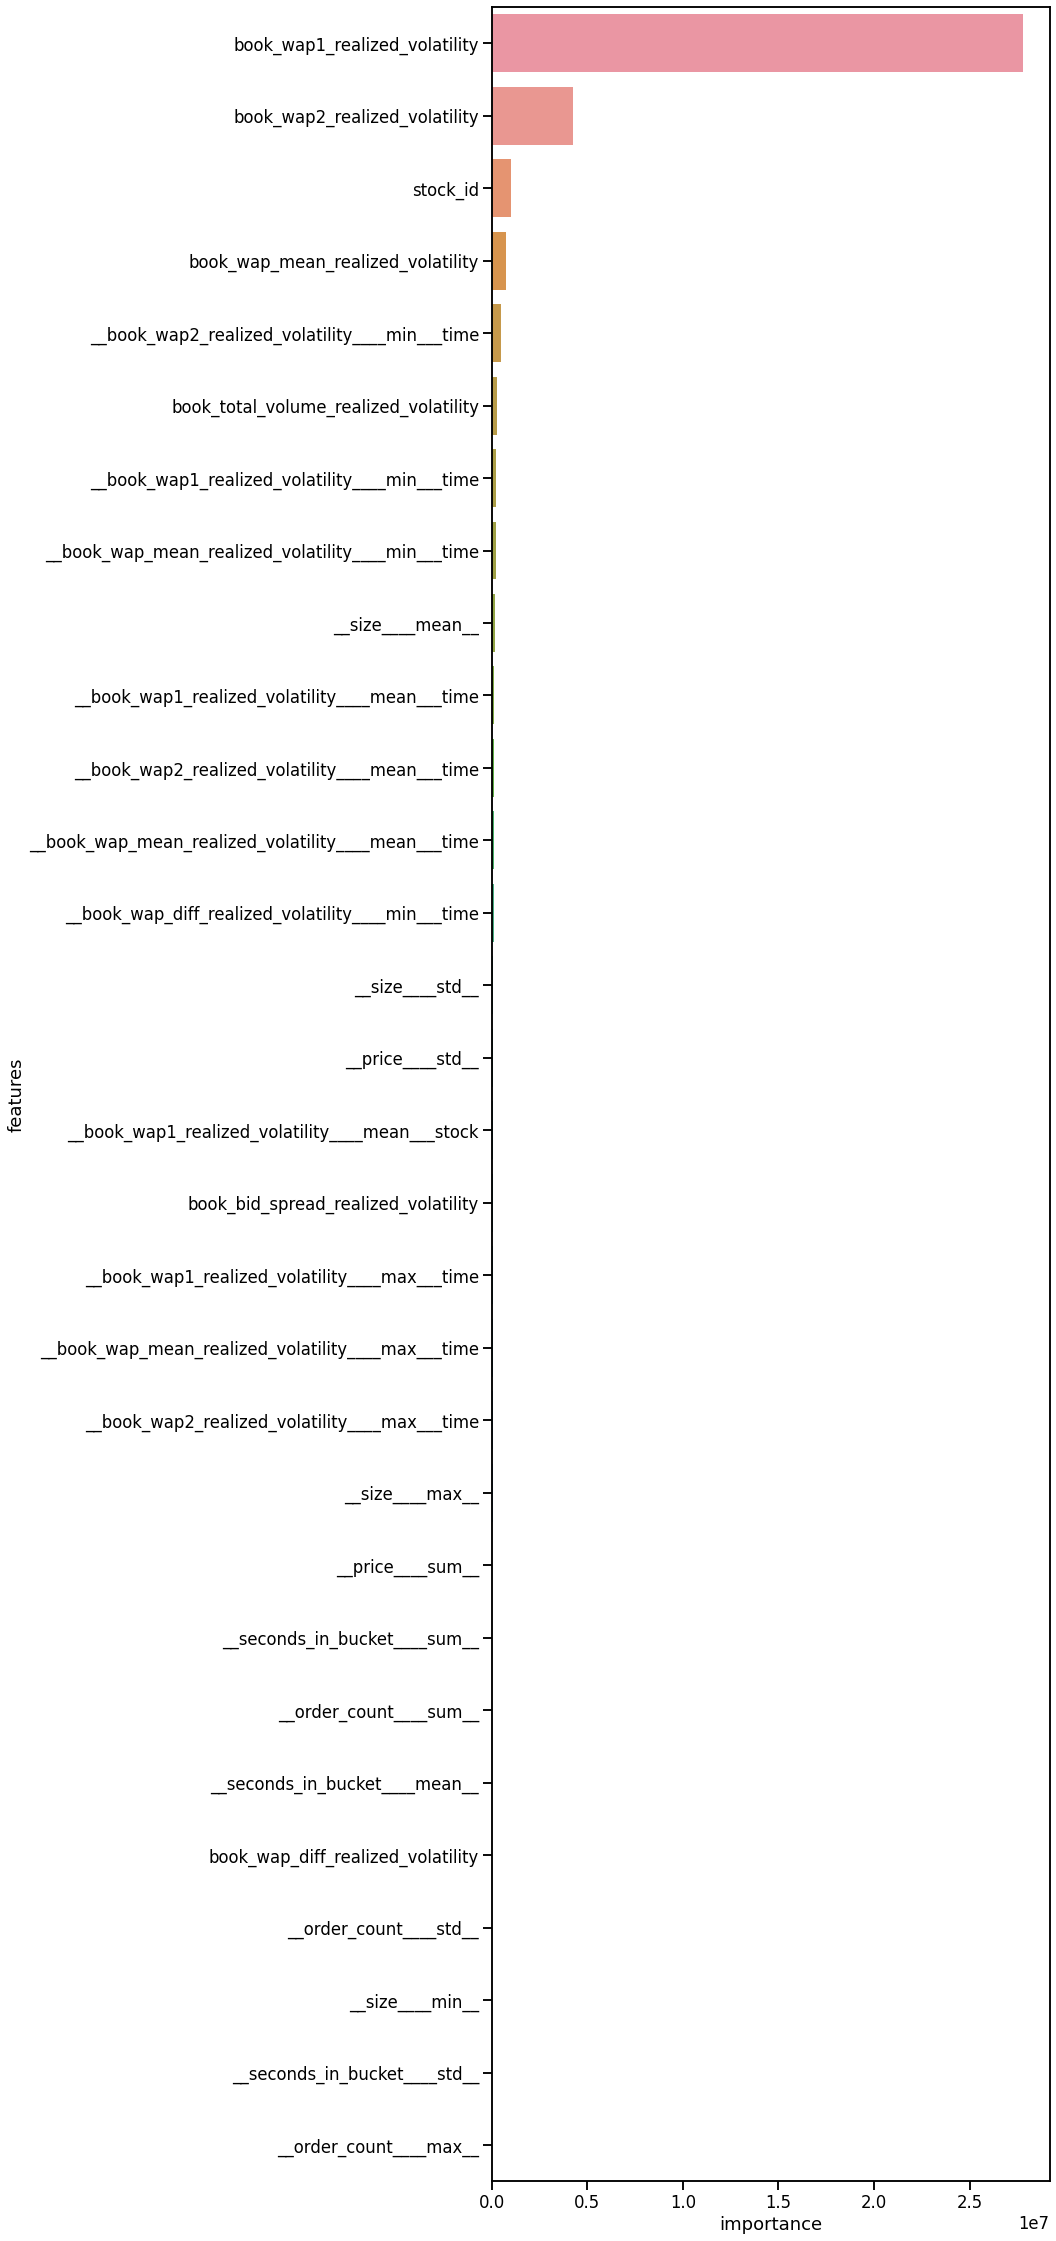

In [29]:
if MODE == 'TRAIN':
    fi_df = fi_df.sort_values(by='importance', ascending=False)
    fi_df.to_csv('feature_importance.csv', index=False)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 40))
    sns.barplot(x='importance', y='features', data=fi_df.iloc[:30], ax=ax)
    logger.info(fi_df[['features', 'importance']].iloc[:50].to_markdown())

# Submit

In [30]:
if MODE == 'INFERENCE':
    """
    used for inference kernel only
    """
    y_preds = np.zeros(len(test_book_df))
    files = glob.glob(f'{MODEL_DIR}/*model*.pkl')
    assert len(files) > 0
    for i, f in enumerate(files):
        model = joblib.load(f)
        y_preds += model.predict(test_book_df[features])
    y_preds /= (i+1)
    
test_book_df[target] = y_preds

In [31]:
# test
test_book_df[target] = y_preds

# save the submit file
sub = test_book_df[['row_id', target]]
sub.to_csv('submission.csv',index = False)

logger.info('submitted!')
sub.head()

submitted!


,row_id,target
0,0-4,0.000756
1,0-32,0.000756
2,0-34,0.000756
